In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision.models import googlenet, resnet18, resnet50
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import sklearn
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

In [64]:
import random
import numpy as np
import torch

seed = 20236
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [14]:
RAVDESS = "test/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "test/cremad/AudioWAV/"
TESS = "test/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "test/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [15]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,test/ravdess-emotional-speech-audio/audio_spee...,male,neutral
1,test/ravdess-emotional-speech-audio/audio_spee...,male,neutral
2,test/ravdess-emotional-speech-audio/audio_spee...,male,neutral
3,test/ravdess-emotional-speech-audio/audio_spee...,male,neutral
4,test/ravdess-emotional-speech-audio/audio_spee...,male,happy


In [16]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,test/cremad/AudioWAV/1001_IEO_ANG_HI.wav,male,angry
1,test/cremad/AudioWAV/1001_IEO_DIS_HI.wav,male,disgust
2,test/cremad/AudioWAV/1001_IEO_FEA_HI.wav,male,fear
3,test/cremad/AudioWAV/1001_IEO_HAP_HI.wav,male,happy
4,test/cremad/AudioWAV/1001_IEO_SAD_HI.wav,male,sad


In [17]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,test/toronto-emotional-speech-set-tess/tess to...,female,angry
1,test/toronto-emotional-speech-set-tess/tess to...,female,angry
2,test/toronto-emotional-speech-set-tess/tess to...,female,angry
3,test/toronto-emotional-speech-set-tess/tess to...,female,angry
4,test/toronto-emotional-speech-set-tess/tess to...,female,angry


In [18]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,test/surrey-audiovisual-expressed-emotion-save...,male,angry
1,test/surrey-audiovisual-expressed-emotion-save...,male,angry
2,test/surrey-audiovisual-expressed-emotion-save...,male,angry
3,test/surrey-audiovisual-expressed-emotion-save...,male,angry
4,test/surrey-audiovisual-expressed-emotion-save...,male,angry


In [19]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,test/ravdess-emotional-speech-audio/audio_spee...,male,neutral
1,test/ravdess-emotional-speech-audio/audio_spee...,male,neutral
2,test/ravdess-emotional-speech-audio/audio_spee...,male,neutral
3,test/ravdess-emotional-speech-audio/audio_spee...,male,neutral
4,test/ravdess-emotional-speech-audio/audio_spee...,male,happy


In [20]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
0,test/ravdess-emotional-speech-audio/audio_spee...,neutral
1,test/ravdess-emotional-speech-audio/audio_spee...,neutral
2,test/ravdess-emotional-speech-audio/audio_spee...,neutral
3,test/ravdess-emotional-speech-audio/audio_spee...,neutral
4,test/ravdess-emotional-speech-audio/audio_spee...,happy


In [65]:
import librosa
from pydub import AudioSegment, effects

In [66]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    if (len(trimmed)>180000):
        padded = trimmed[:180000]
    else:
        padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [12]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

In [23]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

In [14]:
list(emotion_dic.keys())

['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']

In [24]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

In [25]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)

In [48]:
df.iloc[1].path

'test/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav'

In [26]:
class EmotionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.emotion_list = []

        self.FRAME_LENGTH = 2048
        self.HOP_LENGTH = 512

        for row in df.itertuples(index=False):
            self.emotion_list.append(encode(row.emotion))
            
        self.len = len(self.emotion_list)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        y, sr = preprocess_audio(df.iloc[idx].path)
        y = noise(y)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=self.HOP_LENGTH)
        mfccs = mfccs.T.astype('float32')
            
        label = self.emotion_list[idx]
        return mfccs, label

In [16]:
class EmotionDataset(Dataset):
    def __init__(self, images, labels):
        self.images = []
        self.emotions = torch.Tensor(labels).to(torch.int64)
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

        for i in tqdm(range(len(images))):
            
            # MFCC를 이미지로 변환하여 크기를 조정합니다.
            image = Image.fromarray(images[i],"RGB")
            image = transform(image)
            self.images.append(image)
            
        self.len = len(images)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.emotions[idx]
        return image, label

In [49]:
class EmotionDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.emotions = torch.Tensor(labels).to(torch.int64)

    def __len__(self):
        return len(self.emotions)

    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        labels = self.emotions[idx]
        return inputs, labels

In [38]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_shape, hidden_size, n_class):
        super(EmotionLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape[1], hidden_size=hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_class)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :] 
        x = self.fc(x)
        return x

In [50]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_shape, hidden_size, n_class):
        super(EmotionLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape[1], hidden_size=hidden_size, batch_first=True, dropout = 0.3)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, dropout=0.3)
        self.lstm3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size//2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size//2, n_class)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :] 
        x = self.fc(x)
        return x

In [60]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_shape, hidden_size, n_class):
        super(EmotionLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape[1], hidden_size=hidden_size, batch_first=True, dropout = 0.3)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=False, dropout=0.3)
        self.lstm3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size//2, batch_first=False, dropout=0.3)
        self.fc = nn.Linear(hidden_size//2, n_class)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :] 
        x = self.fc(x)
        return x

In [29]:
dataset = EmotionDataset(df)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

TypeError: __init__() missing 1 required positional argument: 'labels'

In [67]:
dataset = EmotionDataset(X,y)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

In [68]:
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

In [81]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [82]:
dataiter = iter(dataloader)
x, labels = next(dataiter)

In [83]:
writer.add_graph(model, x)
writer.close()

In [117]:
y, sr = preprocess_audio("../input.wav")
zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

In [112]:
testX = np.concatenate((
    np.swapaxes(zcr, 0, 1), 
    np.swapaxes(rms, 0, 1), 
    np.swapaxes(mfccs, 0, 1)), 
    axis=1
)
testX = testX.astype('float32')

In [47]:
X.shape[1:3]

(352, 15)

In [33]:
model = EmotionLSTM(X.shape[1:3],256,6)

In [77]:
model = EmotionLSTM(X.shape[1:3],512,6)

In [38]:
model = EmotionLSTM((352, 13),512,6)

In [19]:
model = resnet18(pretrained=True)
num_features = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_features, num_classes) 

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
len(X[0][0])

15

In [73]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')
    return accuracy

In [72]:
from sklearn.metrics import f1_score

In [93]:
def f1score(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predict = []
    label_data = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            label_data = label_data + labels.squeeze().tolist()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predict = predict + predicted.squeeze().tolist()

    accuracy = 100 * correct / total
    f1 = f1_score(label_data, predict,average="macro")
    print(f'Accuracy: {accuracy}%')
    print(f'f1 score: {f1*100}%')
    return accuracy

In [94]:
f1score(model,validation_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.59it/s]

Accuracy: 81.25%
f1 score: 81.48568868514351%


81.25

In [58]:
num_epochs = 200

In [74]:
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    writer.add_scalar('training loss',
                            running_loss / len(dataloader),
                            epoch * len(dataloader) + epoch)
    writer.add_scalar('test acc',
                            test(model,test_loader),
                            epoch * len(dataloader) + epoch)
    torch.save(model.state_dict(), "result/model_LSTM_512_3_{}.pth".format(epoch))
    
print('Training finished!')

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.39it/s]


Test Accuracy: 29.62962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.83it/s]


Test Accuracy: 35.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.86it/s]


Test Accuracy: 39.120370370370374%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.82it/s]


Test Accuracy: 40.27777777777778%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.51it/s]


Test Accuracy: 38.888888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.26it/s]


Test Accuracy: 43.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.57it/s]


Test Accuracy: 43.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.01it/s]


Test Accuracy: 40.27777777777778%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.80it/s]


Test Accuracy: 46.06481481481482%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.22it/s]


Test Accuracy: 47.916666666666664%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.66it/s]


Test Accuracy: 50.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.30it/s]


Test Accuracy: 50.925925925925924%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.34it/s]


Test Accuracy: 45.138888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.94it/s]


Test Accuracy: 50.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.56it/s]


Test Accuracy: 51.620370370370374%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.03it/s]


Test Accuracy: 51.388888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.57it/s]


Test Accuracy: 57.407407407407405%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.65it/s]


Test Accuracy: 52.5462962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.51it/s]


Test Accuracy: 58.7962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.11it/s]


Test Accuracy: 51.620370370370374%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.66it/s]


Test Accuracy: 55.55555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.71it/s]


Test Accuracy: 61.574074074074076%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.55it/s]


Test Accuracy: 61.80555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.39it/s]


Test Accuracy: 54.398148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.64it/s]


Test Accuracy: 61.574074074074076%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.70it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.93it/s]


Test Accuracy: 65.50925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.64it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.65it/s]


Test Accuracy: 64.58333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.52it/s]


Test Accuracy: 65.27777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.72it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.08it/s]


Test Accuracy: 65.50925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.79it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.14it/s]


Test Accuracy: 61.80555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.56it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.47it/s]


Test Accuracy: 63.888888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.03it/s]


Test Accuracy: 69.44444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.83it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.42it/s]


Test Accuracy: 67.82407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.94it/s]


Test Accuracy: 69.67592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.48it/s]


Test Accuracy: 71.06481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.20it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.54it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.37it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.11it/s]


Test Accuracy: 69.67592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 75.63it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 74.25it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.09it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.11it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.80it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.42it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.31it/s]


Test Accuracy: 71.06481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.02it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.56it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.70it/s]


Test Accuracy: 67.82407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 73.37it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.21it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.84it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 73.74it/s]


Test Accuracy: 69.67592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.94it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.41it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.57it/s]


Test Accuracy: 71.52777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.36it/s]


Test Accuracy: 71.06481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.27it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.82it/s]


Test Accuracy: 69.9074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.45it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.25it/s]


Test Accuracy: 71.06481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.08it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.31it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.22it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.80it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.95it/s]


Test Accuracy: 69.44444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.50it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.08it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.11it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.58it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.75it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.71it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.14it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.76it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.39it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.38it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.37it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.27it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.49it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.07it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.57it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.39it/s]


Test Accuracy: 69.9074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.15it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.12it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.18it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.94it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.08it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.41it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.34it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.75it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.19it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.74it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.80it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.25it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.80it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.67it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.03it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.81it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.49it/s]


Test Accuracy: 71.52777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.09it/s]


Test Accuracy: 69.9074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.30it/s]


Test Accuracy: 71.06481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.66it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.50it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.90it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.18it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.08it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.02it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.83it/s]


Test Accuracy: 71.52777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.69it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.00it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.24it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.77it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 73.30it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 75.10it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.73it/s]


Test Accuracy: 71.06481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.11it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.08it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.94it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 74.74it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.50it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.40it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.33it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.20it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.85it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.50it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.88it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.56it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.45it/s]


Test Accuracy: 69.44444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.83it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.78it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 73.89it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.82it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 73.09it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.50it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.18it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.94it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.16it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.59it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 70.55it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.80it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 60.79it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 70.96it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.78it/s]


Test Accuracy: 71.06481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.96it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 62.98it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.71it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.96it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.16it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.08it/s]


Test Accuracy: 69.9074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.02it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.10it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.46it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 74.15it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 66.45it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.23it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 66.08it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.73it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.27it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 70.13it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.28it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.00it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 70.91it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.51it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.57it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 74.84it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.58it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.86it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 66.54it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.40it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 66.35it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 70.95it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 74.68it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 73.46it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.01it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.95it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.69it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.31it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.60it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.79it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.40it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.51it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.61it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.00it/s]


Test Accuracy: 71.52777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.78it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.55it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.37it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.79it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.42it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.86it/s]


Test Accuracy: 75.46296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.74it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.42it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.90it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 72.51it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 73.14it/s]

Test Accuracy: 72.68518518518519%
Training finished!


In [27]:
accuracy_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    accuracy_list.append(test(model,test_loader))
    torch.save(model.state_dict(), "result/model_LSTM_512_3_{}.pth".format(epoch))
    
print('Training finished!')

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.42it/s]


Test Accuracy: 35.18518518518518%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 30.84it/s]


Test Accuracy: 35.879629629629626%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.22it/s]


Test Accuracy: 35.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.63it/s]


Test Accuracy: 38.425925925925924%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.72it/s]


Test Accuracy: 43.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.93it/s]


Test Accuracy: 45.601851851851855%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.69it/s]


Test Accuracy: 43.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.61it/s]


Test Accuracy: 48.148148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.36it/s]


Test Accuracy: 53.7037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.56it/s]


Test Accuracy: 52.5462962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.73it/s]


Test Accuracy: 52.77777777777778%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.82it/s]


Test Accuracy: 51.157407407407405%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.68it/s]


Test Accuracy: 54.166666666666664%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.70it/s]


Test Accuracy: 54.861111111111114%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.51it/s]


Test Accuracy: 55.78703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.82it/s]


Test Accuracy: 53.7037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.63it/s]


Test Accuracy: 56.25%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.41it/s]


Test Accuracy: 58.7962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.79it/s]


Test Accuracy: 55.78703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.01it/s]


Test Accuracy: 53.93518518518518%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.67it/s]


Test Accuracy: 59.49074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.38it/s]


Test Accuracy: 62.5%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.82it/s]


Test Accuracy: 61.342592592592595%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.96it/s]


Test Accuracy: 62.96296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.85it/s]


Test Accuracy: 62.03703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.66it/s]


Test Accuracy: 61.80555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.28it/s]


Test Accuracy: 65.27777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.64it/s]


Test Accuracy: 61.80555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.69it/s]


Test Accuracy: 65.04629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.31it/s]


Test Accuracy: 65.50925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.11it/s]


Test Accuracy: 61.111111111111114%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.51it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.93it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.39it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.96it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.94it/s]


Test Accuracy: 63.888888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.73it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 30.96it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.38it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.47it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.62it/s]


Test Accuracy: 68.05555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.43it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.79it/s]


Test Accuracy: 69.44444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 30.78it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.93it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 29.83it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 30.16it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.06it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.27it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 30.49it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.02it/s]


Test Accuracy: 69.9074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.40it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.44it/s]


Test Accuracy: 70.13888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.75it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.10it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.13it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.76it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.22it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.16it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.21it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 30.73it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.10it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.35it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.90it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.82it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.40it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.09it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.14it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.14it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.68it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.21it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.00it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.54it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.81it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.68it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.89it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.45it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.05it/s]


Test Accuracy: 69.44444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.64it/s]


Test Accuracy: 55.78703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.51it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.92it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.11it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 30.87it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.77it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.85it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.02it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.20it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.63it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.79it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.21it/s]


Test Accuracy: 77.77777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.71it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.28it/s]


Test Accuracy: 76.85185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.80it/s]


Test Accuracy: 73.14814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.18it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.11it/s]


Test Accuracy: 77.77777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.97it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.27it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.67it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.26it/s]


Test Accuracy: 77.77777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.23it/s]


Test Accuracy: 77.77777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.59it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.39it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.18it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.14it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.55it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.26it/s]


Test Accuracy: 76.85185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.66it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.03it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.52it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.31it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.15it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.44it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.47it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.82it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.21it/s]


Test Accuracy: 77.54629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.21it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.14it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.83it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 29.85it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.24it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.54it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.41it/s]


Test Accuracy: 78.24074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:05<00:00, 20.69it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 27.84it/s]


Test Accuracy: 80.78703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:05<00:00, 21.16it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:05<00:00, 20.95it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.48it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:05<00:00, 19.31it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 26.93it/s]


Test Accuracy: 78.93518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.47it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.44it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.61it/s]


Test Accuracy: 78.24074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 28.45it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.68it/s]


Test Accuracy: 77.08333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.96it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.26it/s]


Test Accuracy: 77.77777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.89it/s]


Test Accuracy: 75.46296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.36it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.88it/s]


Test Accuracy: 75.46296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.08it/s]


Test Accuracy: 77.08333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.30it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.16it/s]


Test Accuracy: 78.93518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.29it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.49it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.80it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.99it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.44it/s]


Test Accuracy: 77.77777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.36it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.54it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.19it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.59it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.27it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.17it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.69it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.18it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.76it/s]


Test Accuracy: 77.08333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.73it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.70it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.26it/s]


Test Accuracy: 79.39814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.19it/s]


Test Accuracy: 77.54629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.24it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.51it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.25it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.18it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.71it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.94it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.64it/s]


Test Accuracy: 79.16666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.66it/s]


Test Accuracy: 79.86111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.08it/s]


Test Accuracy: 76.85185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.49it/s]


Test Accuracy: 77.54629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.81it/s]


Test Accuracy: 76.85185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.62it/s]


Test Accuracy: 78.70370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.87it/s]


Test Accuracy: 76.85185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.31it/s]


Test Accuracy: 79.39814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.38it/s]


Test Accuracy: 79.86111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.16it/s]


Test Accuracy: 77.08333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.26it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.24it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.70it/s]


Test Accuracy: 80.0925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.69it/s]


Test Accuracy: 79.16666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.21it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.59it/s]


Test Accuracy: 78.47222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.78it/s]


Test Accuracy: 76.85185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.02it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.37it/s]


Test Accuracy: 77.08333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.44it/s]


Test Accuracy: 77.08333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.88it/s]


Test Accuracy: 78.70370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.21it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.30it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.50it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.63it/s]


Test Accuracy: 78.70370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.67it/s]


Test Accuracy: 77.08333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.66it/s]


Test Accuracy: 80.32407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.54it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.31it/s]


Test Accuracy: 79.16666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.20it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.52it/s]


Test Accuracy: 78.24074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.31it/s]


Test Accuracy: 79.39814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.48it/s]


Test Accuracy: 79.39814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.52it/s]

Test Accuracy: 78.00925925925925%
Training finished!


In [28]:
test(model, validation_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.69it/s]

Test Accuracy: 78.70370370370371%


78.70370370370371

In [53]:
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    test(model,test_loader)
    torch.save(model.state_dict(), "result/model_LSTM_512_{}.pth".format(epoch))
    
print('Training finished!')

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 40.42it/s]


Test Accuracy: 42.129629629629626%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 41.76it/s]


Test Accuracy: 40.0462962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.10it/s]


Test Accuracy: 35.879629629629626%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 41.49it/s]


Test Accuracy: 44.675925925925924%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.08it/s]


Test Accuracy: 43.05555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 41.24it/s]


Test Accuracy: 47.4537037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.09it/s]


Test Accuracy: 53.47222222222222%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.09it/s]


Test Accuracy: 53.00925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.32it/s]


Test Accuracy: 51.620370370370374%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.79it/s]


Test Accuracy: 42.592592592592595%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 46.01it/s]


Test Accuracy: 49.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.51it/s]


Test Accuracy: 40.50925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 40.98it/s]


Test Accuracy: 48.379629629629626%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.05it/s]


Test Accuracy: 56.01851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.55it/s]


Test Accuracy: 56.71296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.52it/s]


Test Accuracy: 57.638888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.27it/s]


Test Accuracy: 55.78703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.40it/s]


Test Accuracy: 59.25925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.14it/s]


Test Accuracy: 58.333333333333336%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.70it/s]


Test Accuracy: 58.7962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.34it/s]


Test Accuracy: 58.7962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.67it/s]


Test Accuracy: 62.5%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.93it/s]


Test Accuracy: 60.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.50it/s]


Test Accuracy: 60.18518518518518%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.80it/s]


Test Accuracy: 60.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.09it/s]


Test Accuracy: 57.407407407407405%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.64it/s]


Test Accuracy: 61.80555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.41it/s]


Test Accuracy: 64.81481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.21it/s]


Test Accuracy: 65.27777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.59it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.68it/s]


Test Accuracy: 65.50925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.64it/s]


Test Accuracy: 68.05555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 41.45it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.49it/s]


Test Accuracy: 59.02777777777778%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.33it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.30it/s]


Test Accuracy: 65.27777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.90it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.44it/s]


Test Accuracy: 63.657407407407405%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.70it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.03it/s]


Test Accuracy: 68.05555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.79it/s]


Test Accuracy: 71.06481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.87it/s]


Test Accuracy: 65.04629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.88it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.45it/s]


Test Accuracy: 71.52777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.33it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.92it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.38it/s]


Test Accuracy: 69.9074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.89it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.97it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.48it/s]


Test Accuracy: 69.67592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.88it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.09it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.26it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.24it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.03it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.15it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.17it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.03it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.77it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.80it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.11it/s]


Test Accuracy: 71.99074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.27it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.96it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.23it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.83it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.75it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.08it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.57it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.99it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.49it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.59it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.36it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.51it/s]


Test Accuracy: 72.91666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.99it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.04it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.40it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.64it/s]


Test Accuracy: 75.46296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 46.08it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.05it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 47.23it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 46.36it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.95it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 43.73it/s]


Test Accuracy: 73.8425925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.60it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.19it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 46.28it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.75it/s]


Test Accuracy: 76.85185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.23it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.44it/s]


Test Accuracy: 71.52777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.22it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.58it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 46.26it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.02it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.84it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.18it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.80it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 46.62it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.84it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.56it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.91it/s]

Test Accuracy: 77.08333333333333%
Training finished!


In [48]:
for epoch in range(60,60+num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    test(model,test_loader)
    torch.save(model.state_dict(), "result/model_LSTM_256_{}.pth".format(epoch))
    
print('Training finished!')

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.62it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 60.34it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.83it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 68.94it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.54it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.33it/s]


Test Accuracy: 72.45370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.83it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.34it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.61it/s]


Test Accuracy: 75.46296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.11it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.23it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.69it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.27it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.62it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.33it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.68it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.81it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.72it/s]


Test Accuracy: 74.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.53it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 69.84it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 70.39it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.36it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 70.53it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 71.98it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 67.32it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 62.44it/s]


Test Accuracy: 76.85185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.20it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.21it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.48it/s]


Test Accuracy: 77.31481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.88it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.66it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.44it/s]


Test Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.36it/s]


Test Accuracy: 74.30555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.11it/s]


Test Accuracy: 77.54629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.67it/s]


Test Accuracy: 78.47222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.99it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.73it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.40it/s]


Test Accuracy: 78.93518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.21it/s]


Test Accuracy: 75.92592592592592%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.15it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.14it/s]


Test Accuracy: 71.75925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.02it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.17it/s]


Test Accuracy: 76.62037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.09it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.43it/s]


Test Accuracy: 78.00925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.46it/s]


Test Accuracy: 70.13888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.90it/s]


Test Accuracy: 72.68518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.64it/s]


Test Accuracy: 74.53703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.07it/s]


Test Accuracy: 75.46296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.36it/s]


Test Accuracy: 73.61111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.47it/s]


Test Accuracy: 75.23148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 61.26it/s]


Test Accuracy: 78.93518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.05it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.35it/s]


Test Accuracy: 76.1574074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.84it/s]


Test Accuracy: 74.07407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 65.58it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 62.88it/s]


Test Accuracy: 75.69444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 64.58it/s]


Test Accuracy: 76.38888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 63.83it/s]


Test Accuracy: 78.47222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 60.82it/s]

Test Accuracy: 78.93518518518519%
Training finished!


In [105]:
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    test(model,test_loader)
    torch.save(model.state_dict(), "result/model_resnet_new_{}.pth".format(epoch))
    
print('Training finished!')

100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.13it/s]


Test Accuracy: 71.47435897435898%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.43it/s]


Test Accuracy: 59.294871794871796%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.58it/s]


Test Accuracy: 75.32051282051282%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.95it/s]


Test Accuracy: 72.11538461538461%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.90it/s]


Test Accuracy: 71.7948717948718%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.26it/s]


Test Accuracy: 72.43589743589743%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.70it/s]


Test Accuracy: 82.05128205128206%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.98it/s]


Test Accuracy: 75.0%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.48it/s]


Test Accuracy: 81.73076923076923%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.97it/s]


Test Accuracy: 76.92307692307692%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.81it/s]


Test Accuracy: 83.33333333333333%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.29it/s]


Test Accuracy: 78.84615384615384%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.91it/s]


Test Accuracy: 83.33333333333333%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.44it/s]


Test Accuracy: 78.2051282051282%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.14it/s]


Test Accuracy: 80.44871794871794%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.03it/s]


Test Accuracy: 81.73076923076923%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 174.60it/s]


Test Accuracy: 77.24358974358974%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.68it/s]


Test Accuracy: 81.73076923076923%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.48it/s]


Test Accuracy: 75.64102564102564%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.52it/s]


Test Accuracy: 83.01282051282051%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 144.95it/s]


Test Accuracy: 72.11538461538461%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.54it/s]


Test Accuracy: 66.98717948717949%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.36it/s]


Test Accuracy: 81.41025641025641%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.59it/s]


Test Accuracy: 83.33333333333333%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.35it/s]


Test Accuracy: 83.65384615384616%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.95it/s]


Test Accuracy: 81.73076923076923%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.69it/s]


Test Accuracy: 78.2051282051282%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.26it/s]


Test Accuracy: 80.44871794871794%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.36it/s]


Test Accuracy: 83.65384615384616%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.97it/s]


Test Accuracy: 77.24358974358974%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.97it/s]


Test Accuracy: 79.16666666666667%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.71it/s]


Test Accuracy: 79.16666666666667%


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.45it/s]


Test Accuracy: 80.12820512820512%


Epoch [34/60]:  52%|███████████████████████████▏                        | 82/157 [00:03<00:03, 22.93it/s, loss=0.00913]


KeyboardInterrupt: 

## 한글

In [17]:
dataset = EmotionDataset(X,y)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

In [18]:
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

In [19]:
model = EmotionLSTM(X.shape[1:3],512,6)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 200

In [26]:
accuracy_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    accuracy_list.append(test(model,test_loader))
    torch.save(model.state_dict(), "result/model_LSTM_512_3_korean_{}.pth".format(epoch))
    
print('Training finished!')

100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.75it/s]


Test Accuracy: 38.8034188034188%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.84it/s]


Test Accuracy: 38.97435897435897%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.68it/s]


Test Accuracy: 42.43589743589744%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.78it/s]


Test Accuracy: 45.72649572649573%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.87it/s]


Test Accuracy: 45.64102564102564%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.60it/s]


Test Accuracy: 45.98290598290598%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.74it/s]


Test Accuracy: 47.17948717948718%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.91it/s]


Test Accuracy: 46.324786324786324%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 34.17it/s]


Test Accuracy: 45.51282051282051%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 34.05it/s]


Test Accuracy: 45.55555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 34.01it/s]


Test Accuracy: 47.26495726495727%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.83it/s]


Test Accuracy: 46.75213675213675%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.79it/s]


Test Accuracy: 48.333333333333336%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.75it/s]


Test Accuracy: 46.88034188034188%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.81it/s]


Test Accuracy: 46.282051282051285%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.85it/s]


Test Accuracy: 48.547008547008545%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.51it/s]


Test Accuracy: 49.05982905982906%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.77it/s]


Test Accuracy: 47.99145299145299%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.50it/s]


Test Accuracy: 50.2991452991453%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.91it/s]


Test Accuracy: 51.452991452991455%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.88it/s]


Test Accuracy: 50.72649572649573%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.01it/s]


Test Accuracy: 51.965811965811966%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.46it/s]


Test Accuracy: 51.495726495726494%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.86it/s]


Test Accuracy: 51.06837606837607%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.64it/s]


Test Accuracy: 50.51282051282051%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.54it/s]


Test Accuracy: 50.34188034188034%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:18<00:00, 32.27it/s]


Test Accuracy: 51.452991452991455%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.69it/s]


Test Accuracy: 52.35042735042735%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.99it/s]


Test Accuracy: 53.333333333333336%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.63it/s]


Test Accuracy: 51.452991452991455%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:18<00:00, 31.91it/s]


Test Accuracy: 51.88034188034188%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:18<00:00, 32.41it/s]


Test Accuracy: 52.52136752136752%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.90it/s]


Test Accuracy: 54.23076923076923%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:18<00:00, 32.24it/s]


Test Accuracy: 52.43589743589744%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:18<00:00, 32.14it/s]


Test Accuracy: 51.36752136752137%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.42it/s]


Test Accuracy: 52.69230769230769%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.74it/s]


Test Accuracy: 55.256410256410255%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.43it/s]


Test Accuracy: 53.63247863247863%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.88it/s]


Test Accuracy: 54.82905982905983%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.69it/s]


Test Accuracy: 52.22222222222222%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.69it/s]


Test Accuracy: 54.52991452991453%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.74it/s]


Test Accuracy: 55.085470085470085%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.20it/s]


Test Accuracy: 53.11965811965812%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.41it/s]


Test Accuracy: 53.29059829059829%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.56it/s]


Test Accuracy: 52.56410256410256%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.47it/s]


Test Accuracy: 55.81196581196581%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.70it/s]


Test Accuracy: 55.38461538461539%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.76it/s]


Test Accuracy: 54.31623931623932%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.30it/s]


Test Accuracy: 55.427350427350426%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.41it/s]


Test Accuracy: 55.17094017094017%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.89it/s]


Test Accuracy: 55.598290598290596%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.42it/s]


Test Accuracy: 56.1965811965812%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.63it/s]


Test Accuracy: 54.48717948717949%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.73it/s]


Test Accuracy: 54.65811965811966%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.37it/s]


Test Accuracy: 55.98290598290598%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.11it/s]


Test Accuracy: 55.94017094017094%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.42it/s]


Test Accuracy: 54.914529914529915%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 34.26it/s]


Test Accuracy: 56.324786324786324%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.83it/s]


Test Accuracy: 55.85470085470085%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.16it/s]


Test Accuracy: 57.05128205128205%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.72it/s]


Test Accuracy: 55.68376068376068%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.65it/s]


Test Accuracy: 55.17094017094017%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.72it/s]


Test Accuracy: 55.21367521367522%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:18<00:00, 32.46it/s]


Test Accuracy: 56.1965811965812%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.01it/s]


Test Accuracy: 54.18803418803419%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.90it/s]


Test Accuracy: 56.15384615384615%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.76it/s]


Test Accuracy: 56.02564102564103%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:18<00:00, 32.21it/s]


Test Accuracy: 53.717948717948715%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.82it/s]


Test Accuracy: 54.52991452991453%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:18<00:00, 31.96it/s]


Test Accuracy: 54.31623931623932%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 34.04it/s]


Test Accuracy: 56.623931623931625%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 34.33it/s]


Test Accuracy: 55.81196581196581%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.51it/s]


Test Accuracy: 55.427350427350426%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.41it/s]


Test Accuracy: 54.23076923076923%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.72it/s]


Test Accuracy: 55.17094017094017%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.38it/s]


Test Accuracy: 55.8974358974359%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.64it/s]


Test Accuracy: 55.98290598290598%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 34.15it/s]


Test Accuracy: 55.38461538461539%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.20it/s]


Test Accuracy: 55.427350427350426%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.72it/s]


Test Accuracy: 54.914529914529915%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.97it/s]


Test Accuracy: 55.72649572649573%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.10it/s]


Test Accuracy: 56.495726495726494%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.98it/s]


Test Accuracy: 55.0%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.28it/s]


Test Accuracy: 55.427350427350426%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.79it/s]


Test Accuracy: 55.0%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.27it/s]


Test Accuracy: 55.042735042735046%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.31it/s]


Test Accuracy: 54.61538461538461%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.26it/s]


Test Accuracy: 53.76068376068376%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.04it/s]


Test Accuracy: 55.085470085470085%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.09it/s]


Test Accuracy: 54.65811965811966%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.01it/s]


Test Accuracy: 55.85470085470085%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.94it/s]


Test Accuracy: 54.401709401709404%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.91it/s]


Test Accuracy: 55.68376068376068%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 35.02it/s]


Test Accuracy: 55.76923076923077%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:16<00:00, 34.70it/s]


Test Accuracy: 54.914529914529915%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.97it/s]


Test Accuracy: 54.957264957264954%


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 33.40it/s]


Test Accuracy: 56.15384615384615%


Epoch [98/200]:  36%|██████████████████▍                                | 423/1171 [00:34<01:00, 12.40it/s, loss=0.103]


KeyboardInterrupt: 

In [53]:
state = torch.load("result/model_LSTM_512_3_71.pth")
model.load_state_dict(state)

<All keys matched successfully>

In [27]:
model.eval()
correct = 0
total = 0
actual = []
predict= []

with torch.no_grad():
    for images, labels in tqdm(validation_loader):
        actual = actual + labels.squeeze().tolist()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predict = predict + predicted.squeeze().tolist()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy}%')

100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:17<00:00, 32.97it/s]

Test Accuracy: 55.98290598290598%


In [ ]:
decode_dict = {3 : 'angry',5 : 'disgust', 4 : 'fear', 1 : 'happy', 0: 'neutral', 2 : 'sad'}
def decode(idx): return decode_dict[idx]

<AxesSubplot:>

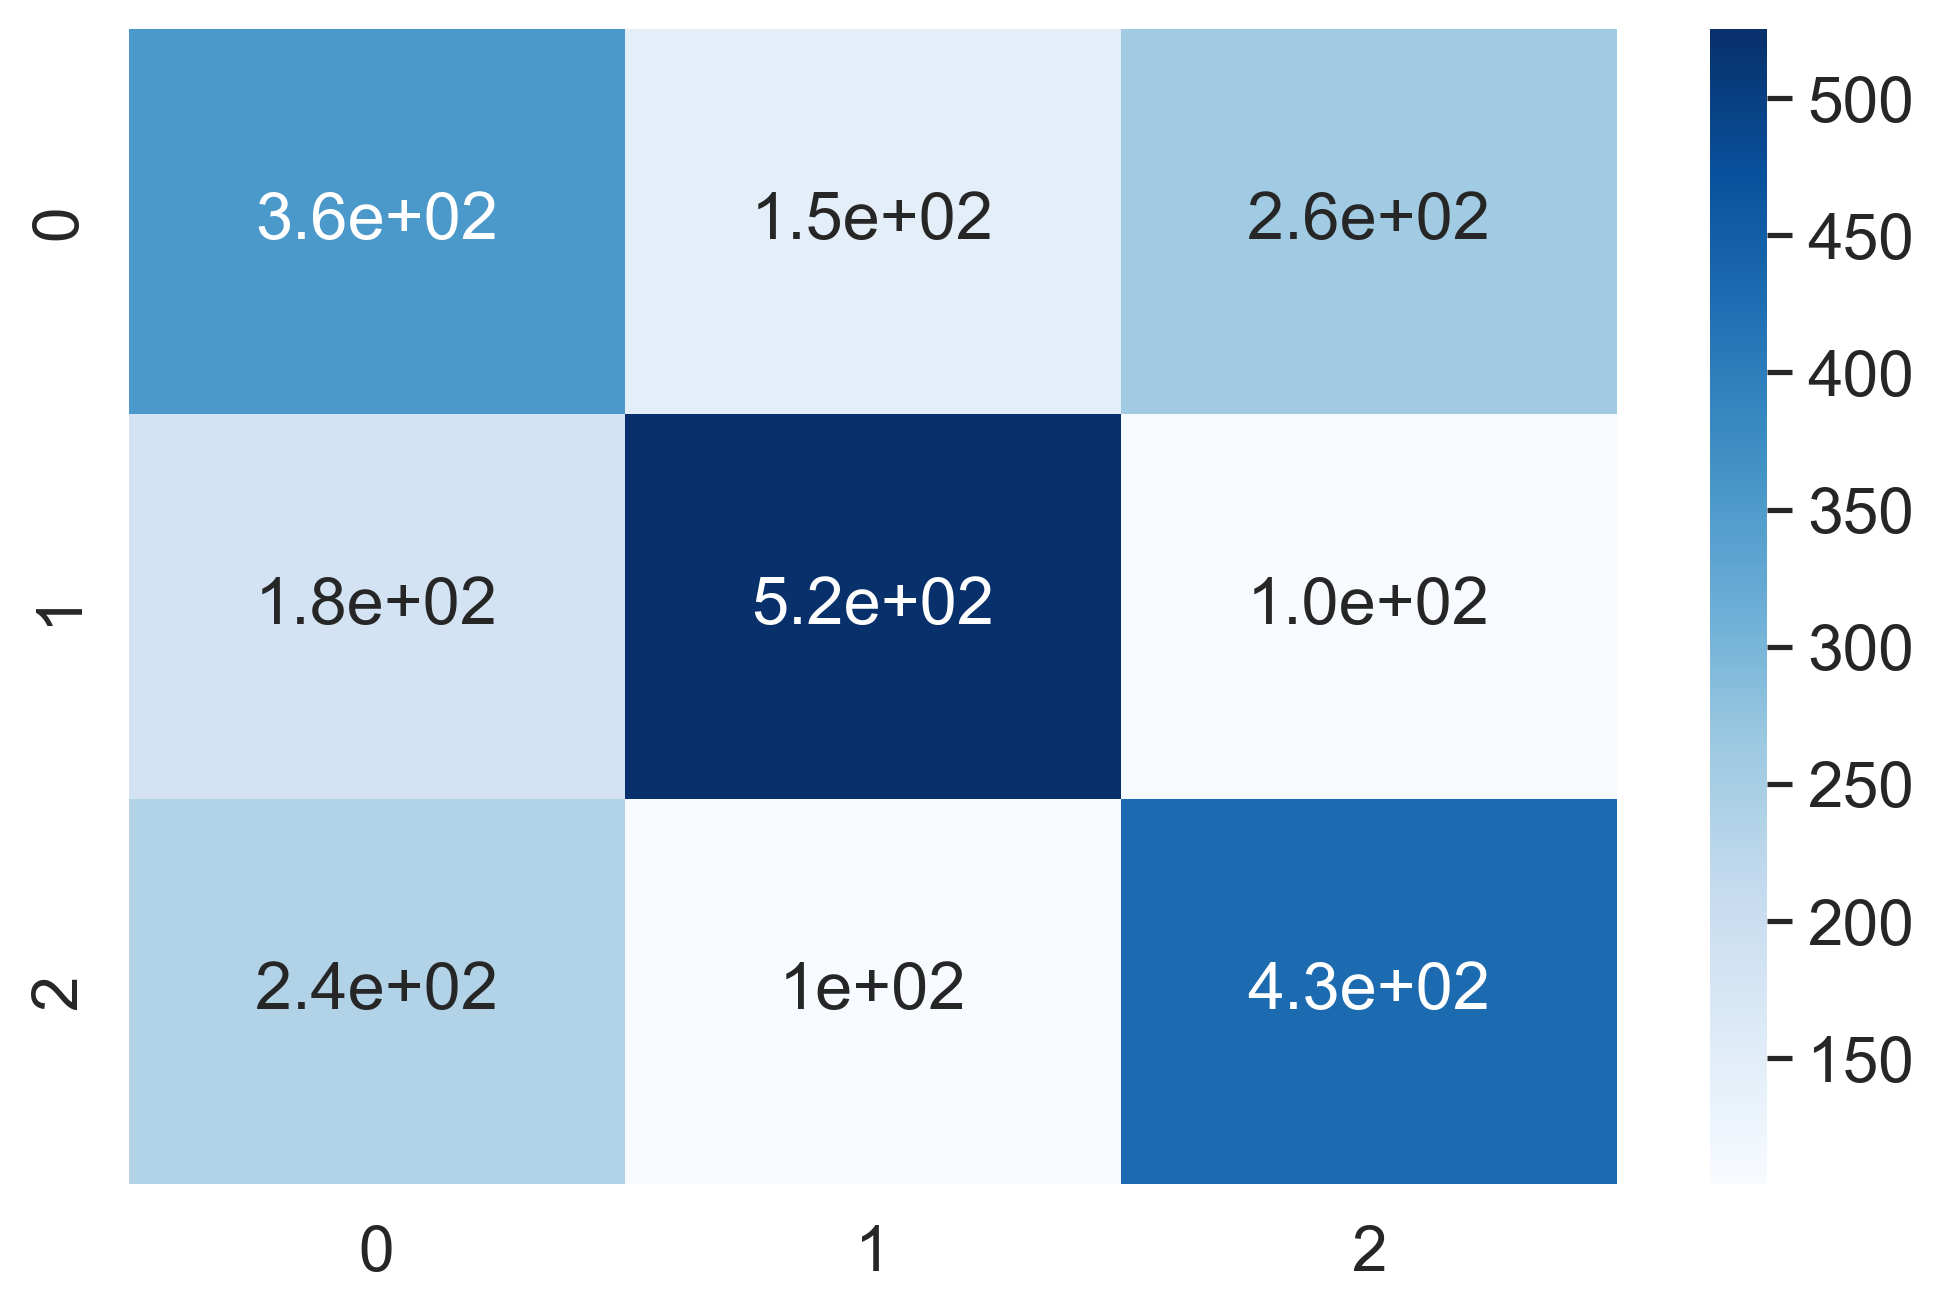

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline
cm = confusion_matrix(predict,actual)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, cmap='Blues')# font size

<AxesSubplot:>

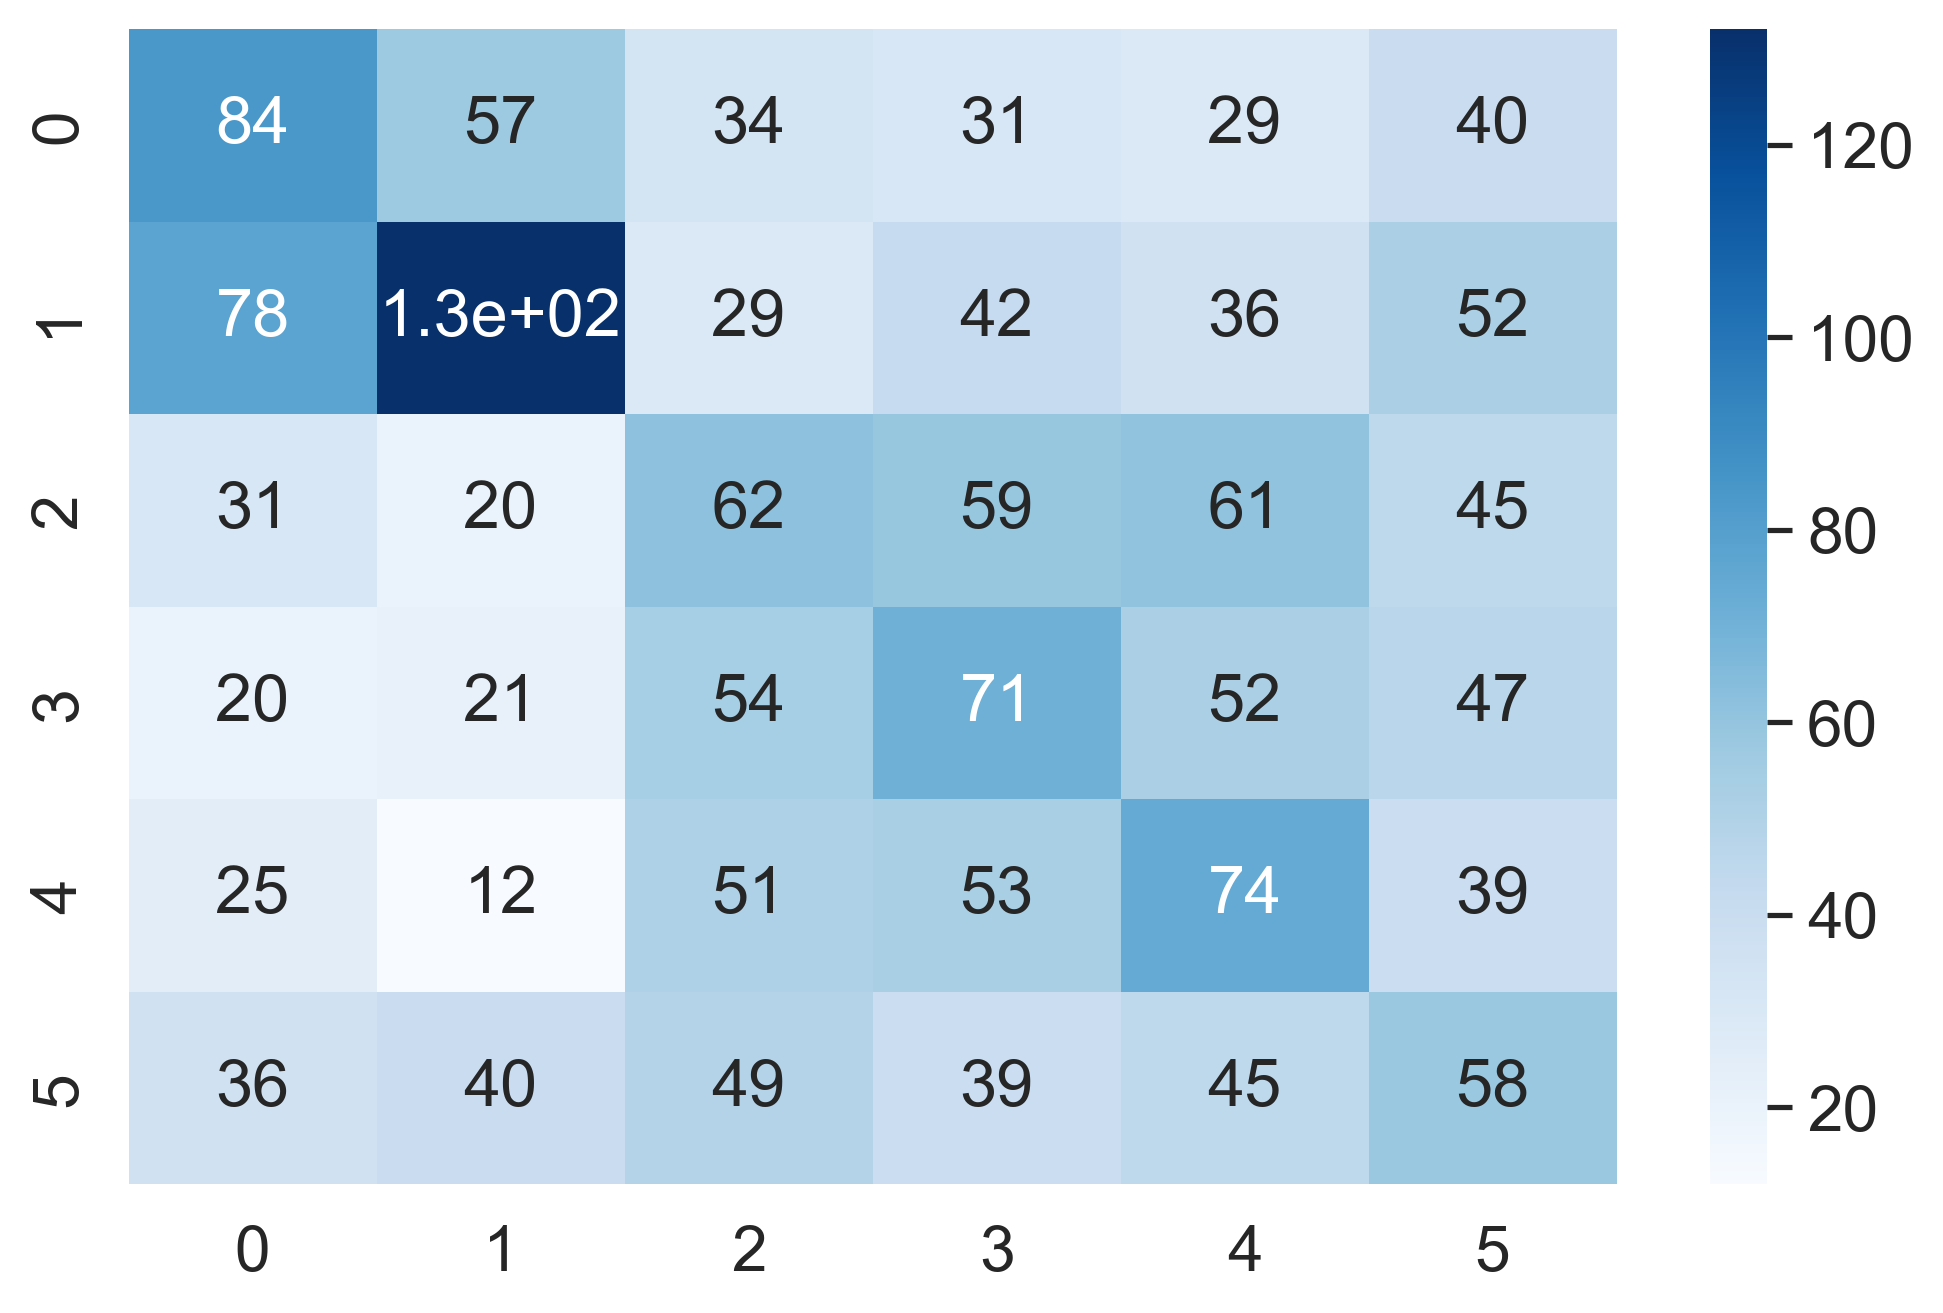

In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline
cm = confusion_matrix(predict,actual)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, cmap='Blues')# font size

## 남녀 데이터 둘다

In [106]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
1,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
2,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
3,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
4,ravdess-emotional-speech-audio/audio_speech_ac...,male,happy


In [107]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_a13.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_a14.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_d01.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_d04.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_d08.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_d09.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_d10.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_d13.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_d14.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_d15.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_f11.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/DC_

Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_h15.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_n11.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_n14.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_sa04.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_sa05.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_sa10.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_sa11.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_sa12.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_sa13.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_sa14.wav
Failed for path: surrey-audiovisual-expressed-emotion-savee/ALL/KL_sa15.wav


In [108]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)

In [109]:
dataset = EmotionDataset(X,y)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

100%|█████████████████████████████████████████████████████████████████████████████| 4211/4211 [00:05<00:00, 749.53it/s]


In [110]:
model = resnet18(pretrained=True)
num_features = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_features, num_classes) 

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [112]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [24]:
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    test(model,test_loader)
    torch.save(model.state_dict(), "result/model_resnet_new_all_{}.pth".format(epoch))
    
print('Training finished!')

100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 177.73it/s]


Test Accuracy: 36.342592592592595%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 166.05it/s]


Test Accuracy: 56.71296296296296%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 178.52it/s]


Test Accuracy: 56.71296296296296%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 174.30it/s]


Test Accuracy: 62.5%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 172.41it/s]


Test Accuracy: 59.72222222222222%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 181.82it/s]


Test Accuracy: 63.425925925925924%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 167.38it/s]


Test Accuracy: 64.12037037037037%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 176.56it/s]


Test Accuracy: 64.35185185185185%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 174.68it/s]


Test Accuracy: 65.74074074074075%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 175.31it/s]


Test Accuracy: 60.416666666666664%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 177.89it/s]


Test Accuracy: 62.96296296296296%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 169.96it/s]


Test Accuracy: 65.50925925925925%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 165.96it/s]


Test Accuracy: 59.02777777777778%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 164.84it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 164.11it/s]


Test Accuracy: 62.5%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 164.98it/s]


Test Accuracy: 63.657407407407405%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 173.07it/s]


Test Accuracy: 65.27777777777777%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 178.47it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 166.91it/s]


Test Accuracy: 66.66666666666667%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 172.42it/s]


Test Accuracy: 63.19444444444444%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 174.90it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 171.92it/s]


Test Accuracy: 67.5925925925926%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 171.58it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 156.19it/s]


Test Accuracy: 63.888888888888886%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 169.56it/s]


Test Accuracy: 64.81481481481481%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 169.94it/s]


Test Accuracy: 66.66666666666667%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 167.63it/s]


Test Accuracy: 64.35185185185185%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 171.12it/s]


Test Accuracy: 67.5925925925926%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 167.65it/s]


Test Accuracy: 67.36111111111111%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 152.43it/s]


Test Accuracy: 66.43518518518519%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 166.58it/s]


Test Accuracy: 66.43518518518519%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 169.16it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 160.93it/s]


Test Accuracy: 65.04629629629629%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 157.40it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 166.72it/s]


Test Accuracy: 66.89814814814815%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 170.51it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 164.52it/s]


Test Accuracy: 65.74074074074075%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 170.33it/s]


Test Accuracy: 62.96296296296296%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 162.60it/s]


Test Accuracy: 66.66666666666667%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 176.37it/s]


Test Accuracy: 65.97222222222223%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 154.82it/s]


Test Accuracy: 65.74074074074075%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 164.28it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 171.40it/s]


Test Accuracy: 65.97222222222223%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 172.22it/s]


Test Accuracy: 66.43518518518519%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 167.27it/s]


Test Accuracy: 64.58333333333333%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 165.50it/s]


Test Accuracy: 67.82407407407408%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 166.94it/s]


Test Accuracy: 66.43518518518519%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 170.48it/s]


Test Accuracy: 65.27777777777777%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 168.46it/s]


Test Accuracy: 63.425925925925924%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 167.52it/s]


Test Accuracy: 63.888888888888886%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 169.46it/s]


Test Accuracy: 66.20370370370371%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 157.87it/s]


Test Accuracy: 70.13888888888889%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 169.70it/s]


Test Accuracy: 71.06481481481481%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 172.22it/s]


Test Accuracy: 67.5925925925926%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 164.70it/s]


Test Accuracy: 63.657407407407405%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 168.31it/s]


Test Accuracy: 70.37037037037037%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 171.57it/s]


Test Accuracy: 67.36111111111111%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 171.17it/s]


Test Accuracy: 66.43518518518519%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 171.95it/s]


Test Accuracy: 64.58333333333333%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 167.70it/s]

Test Accuracy: 67.82407407407408%
Training finished!


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 123.31it/s]

Test Accuracy: 80.76923076923077%


80.76923076923077

## googlenet

In [25]:
model = googlenet(pretrained=True)
num_features = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_features, num_classes) 

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [28]:
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)                                                                          
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    test(model,test_loader)
    torch.save(model.state_dict(), "result/model_googlenet_new_all_{}.pth".format(epoch))
    
print('Training finished!')

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.60it/s]


Test Accuracy: 19.675925925925927%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.06it/s]


Test Accuracy: 46.99074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.92it/s]


Test Accuracy: 59.49074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.00it/s]


Test Accuracy: 60.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.95it/s]


Test Accuracy: 56.94444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.79it/s]


Test Accuracy: 50.0%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.61it/s]


Test Accuracy: 64.12037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.96it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.31it/s]


Test Accuracy: 62.26851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.22it/s]


Test Accuracy: 60.416666666666664%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.87it/s]


Test Accuracy: 65.04629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 75.45it/s]


Test Accuracy: 59.49074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.23it/s]


Test Accuracy: 60.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.13it/s]


Test Accuracy: 63.888888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.84it/s]


Test Accuracy: 62.96296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.55it/s]


Test Accuracy: 64.58333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.01it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.34it/s]


Test Accuracy: 66.66666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.77it/s]


Test Accuracy: 66.89814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.91it/s]


Test Accuracy: 64.81481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.67it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.55it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.48it/s]


Test Accuracy: 68.05555555555556%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.64it/s]


Test Accuracy: 60.18518518518518%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 75.78it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.75it/s]


Test Accuracy: 62.03703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.44it/s]


Test Accuracy: 66.89814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.61it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.75it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.78it/s]


Test Accuracy: 62.96296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.38it/s]


Test Accuracy: 63.657407407407405%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.21it/s]


Test Accuracy: 64.81481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.21it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.61it/s]


Test Accuracy: 60.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.69it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.17it/s]


Test Accuracy: 66.89814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.35it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.34it/s]


Test Accuracy: 62.73148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.42it/s]


Test Accuracy: 58.333333333333336%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.67it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.90it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.96it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.97it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.45it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.20it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.95it/s]


Test Accuracy: 64.58333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.18it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.14it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.78it/s]


Test Accuracy: 70.83333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.87it/s]


Test Accuracy: 63.657407407407405%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.12it/s]


Test Accuracy: 72.22222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 77.98it/s]


Test Accuracy: 66.66666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.73it/s]


Test Accuracy: 66.66666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.34it/s]


Test Accuracy: 71.29629629629629%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.46it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.98it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 74.38it/s]


Test Accuracy: 73.37962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 79.70it/s]


Test Accuracy: 70.37037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 81.58it/s]


Test Accuracy: 70.60185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.06it/s]

Test Accuracy: 66.89814814814815%
Training finished!


In [29]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    if (len(trimmed)>240000):
        padded = trimmed[:240000]
    else:
        padded = np.pad(trimmed, (0, 240000-len(trimmed)), 'constant')
    return padded, sr

In [30]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

In [31]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)

In [32]:
dataset = EmotionDataset(X,y)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

100%|█████████████████████████████████████████████████████████████████████████████| 4331/4331 [00:06<00:00, 652.57it/s]


In [33]:
model = resnet18(pretrained=True)
num_features = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_features, num_classes) 

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [35]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [36]:
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)                                                                          
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    test(model,test_loader)
    torch.save(model.state_dict(), "result/model_resnet_240000_all_{}.pth".format(epoch))
    
print('Training finished!')

100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 128.65it/s]


Test Accuracy: 28.47222222222222%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 135.45it/s]


Test Accuracy: 54.398148148148145%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 124.05it/s]


Test Accuracy: 46.75925925925926%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 117.92it/s]


Test Accuracy: 65.97222222222223%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 133.61it/s]


Test Accuracy: 60.648148148148145%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 123.04it/s]


Test Accuracy: 63.19444444444444%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 111.61it/s]


Test Accuracy: 61.342592592592595%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 134.71it/s]


Test Accuracy: 66.43518518518519%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 133.13it/s]


Test Accuracy: 62.96296296296296%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.33it/s]


Test Accuracy: 53.7037037037037%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 136.07it/s]


Test Accuracy: 60.648148148148145%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 118.90it/s]


Test Accuracy: 62.5%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 127.28it/s]


Test Accuracy: 66.43518518518519%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 136.19it/s]


Test Accuracy: 66.89814814814815%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 121.87it/s]


Test Accuracy: 68.51851851851852%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 113.92it/s]


Test Accuracy: 65.27777777777777%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 137.18it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 126.57it/s]


Test Accuracy: 64.58333333333333%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 131.92it/s]


Test Accuracy: 61.111111111111114%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.82it/s]


Test Accuracy: 65.04629629629629%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.95it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 133.71it/s]


Test Accuracy: 66.66666666666667%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.46it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 121.36it/s]


Test Accuracy: 70.37037037037037%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 133.50it/s]


Test Accuracy: 66.43518518518519%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 127.67it/s]


Test Accuracy: 66.89814814814815%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.15it/s]


Test Accuracy: 68.28703703703704%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 126.16it/s]


Test Accuracy: 71.75925925925925%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 123.59it/s]


Test Accuracy: 68.28703703703704%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 134.12it/s]


Test Accuracy: 67.82407407407408%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.46it/s]


Test Accuracy: 69.44444444444444%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 115.62it/s]


Test Accuracy: 62.73148148148148%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 133.26it/s]


Test Accuracy: 67.36111111111111%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 123.72it/s]


Test Accuracy: 67.82407407407408%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 128.63it/s]


Test Accuracy: 65.04629629629629%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 115.63it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 120.81it/s]


Test Accuracy: 69.44444444444444%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 123.09it/s]


Test Accuracy: 68.28703703703704%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.97it/s]


Test Accuracy: 69.44444444444444%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 127.68it/s]


Test Accuracy: 66.66666666666667%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 136.90it/s]


Test Accuracy: 67.82407407407408%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 127.14it/s]


Test Accuracy: 68.51851851851852%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 137.57it/s]


Test Accuracy: 69.9074074074074%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 123.84it/s]


Test Accuracy: 71.75925925925925%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 123.37it/s]


Test Accuracy: 66.89814814814815%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.07it/s]


Test Accuracy: 66.66666666666667%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 126.39it/s]


Test Accuracy: 66.20370370370371%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 134.49it/s]


Test Accuracy: 68.51851851851852%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 130.01it/s]


Test Accuracy: 70.60185185185185%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 123.05it/s]


Test Accuracy: 68.51851851851852%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 130.70it/s]


Test Accuracy: 66.89814814814815%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 127.07it/s]


Test Accuracy: 67.5925925925926%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 135.52it/s]


Test Accuracy: 69.21296296296296%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.03it/s]


Test Accuracy: 68.75%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 128.07it/s]


Test Accuracy: 68.28703703703704%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 133.53it/s]


Test Accuracy: 67.12962962962963%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 129.20it/s]


Test Accuracy: 70.13888888888889%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 135.58it/s]


Test Accuracy: 67.5925925925926%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 124.95it/s]


Test Accuracy: 67.82407407407408%


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 125.80it/s]

Test Accuracy: 65.50925925925925%
Training finished!


In [37]:
model = googlenet(pretrained=True)
num_features = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_features, num_classes) 

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [39]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [40]:
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)                                                                          
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    test(model,test_loader)
    torch.save(model.state_dict(), "result/model_googlenet_240000_all_{}.pth".format(epoch))
    
print('Training finished!')

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 54.02it/s]


Test Accuracy: 46.75925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 54.32it/s]


Test Accuracy: 50.925925925925924%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.93it/s]


Test Accuracy: 43.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.96it/s]


Test Accuracy: 55.78703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 53.16it/s]


Test Accuracy: 65.27777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.97it/s]


Test Accuracy: 59.49074074074074%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.80it/s]


Test Accuracy: 64.12037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 54.88it/s]


Test Accuracy: 64.58333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.10it/s]


Test Accuracy: 53.7037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.16it/s]


Test Accuracy: 58.7962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.83it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.32it/s]


Test Accuracy: 52.77777777777778%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.37it/s]


Test Accuracy: 40.27777777777778%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.43it/s]


Test Accuracy: 61.342592592592595%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.45it/s]


Test Accuracy: 60.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 53.50it/s]


Test Accuracy: 60.416666666666664%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 52.83it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.57it/s]


Test Accuracy: 60.879629629629626%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.97it/s]


Test Accuracy: 63.19444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 52.93it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.10it/s]


Test Accuracy: 62.5%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.27it/s]


Test Accuracy: 51.388888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 53.93it/s]


Test Accuracy: 63.19444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 54.33it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.52it/s]


Test Accuracy: 54.398148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.68it/s]


Test Accuracy: 65.27777777777777%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.29it/s]


Test Accuracy: 52.77777777777778%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.88it/s]


Test Accuracy: 63.657407407407405%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 58.63it/s]


Test Accuracy: 63.425925925925924%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.01it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 53.97it/s]


Test Accuracy: 59.25925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.26it/s]


Test Accuracy: 63.888888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 54.73it/s]


Test Accuracy: 63.425925925925924%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 53.08it/s]


Test Accuracy: 64.12037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.09it/s]


Test Accuracy: 64.81481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.77it/s]


Test Accuracy: 66.89814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.22it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.14it/s]


Test Accuracy: 66.89814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.07it/s]


Test Accuracy: 64.12037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.88it/s]


Test Accuracy: 62.73148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.72it/s]


Test Accuracy: 63.19444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.91it/s]


Test Accuracy: 64.12037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.54it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 50.77it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.34it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 54.62it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.05it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.90it/s]


Test Accuracy: 63.425925925925924%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.54it/s]


Test Accuracy: 63.19444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.96it/s]


Test Accuracy: 63.19444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.42it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.26it/s]


Test Accuracy: 60.879629629629626%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 54.83it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.39it/s]


Test Accuracy: 64.12037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.03it/s]


Test Accuracy: 66.89814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 57.65it/s]


Test Accuracy: 64.12037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.24it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 55.18it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 53.82it/s]


Test Accuracy: 65.50925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 53.71it/s]

Test Accuracy: 59.49074074074074%
Training finished!


### 한글 감정 데이터 확인

In [54]:
df = pd.read_csv("datasets/emotion.csv")

In [55]:
df = df[["wav_id","상황"]]

In [56]:
n = pd.concat([
    df[df["상황"]=="anger"],
    df[df["상황"]=="angry"],
    df[df["상황"]=="disgust"],
    df[df["상황"]=="fear"]
], axis=0).sample(7810)
p = pd.concat([
    df[df["상황"]=="happy"],
    df[df["상황"]=="happiness"],
    df[df["상황"]=="neutral"]
], axis=0).sample(7810)
s = pd.concat([
    df[df["상황"]=="sad"],
    df[df["상황"]=="sadness"]
], axis=0).sample(7810)

In [64]:
print(len(n),len(p),len(s))

20426 7810 14000


In [8]:
df = pd.concat([n,p,s])

In [57]:
a = pd.concat([
    df[df["상황"]=="anger"],
    df[df["상황"]=="angry"]
], axis=0).sample(2848)
d = df[df["상황"]=="disgust"].sample(2848)
f = df[df["상황"]=="fear"].sample(2848)
h = pd.concat([
    df[df["상황"]=="happy"],
    df[df["상황"]=="happiness"]
], axis=0).sample(2848)
n = df[df["상황"]=="neutral"].sample(2848)
s = pd.concat([
    df[df["상황"]=="sad"],
    df[df["상황"]=="sadness"]
], axis=0).sample(2848)

In [58]:
df = pd.concat([a,d,f,h,n,s])

In [27]:
print(len(df[df["상황"]=="anger"]),len(df[df["상황"]=="angry"]),len(df[df["상황"]=="disgust"]),
      len(df[df["상황"]=="fear"]),len(df[df["상황"]=="happy"]),len(df[df["상황"]=="happiness"]),
      len(df[df["상황"]=="neutral"]), len(df[df["상황"]=="sad"]),len(df[df["상황"]=="sadness"]))

2060 788 2848 2848 0 2848 2848 2264 584


In [59]:
from tqdm import tqdm

In [10]:
emotion_dic = {'anger': 0, 'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 1, 'happiness': 1,
                               'neutral': 1, 'sad': 2, 'sadness': 2, 'surprise': 6}
def encode(label):
    return emotion_dic.get(label)

In [60]:
emotion_dic = {'anger': 3, 'angry': 3, 'disgust': 5, 'fear': 4, 'happy': 1, 'happiness': 1,
                               'neutral': 0, 'sad': 2, 'sadness': 2, 'surprise': 6}

def encode(label):
    return emotion_dic.get(label)

In [11]:
import librosa
from pydub import AudioSegment, effects

In [51]:
from pydub.playback import play

In [118]:
path = "datasets/emotion_audio_data/"+df.iloc[3][0]+".wav"
path = "test/cremad/AudioWAV/1001_DFA_ANG_XX.wav"
raw_audio = AudioSegment.from_file(path)
effects.normalize(raw_audio)
play(raw_audio+10)

In [141]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    effects.normalize(raw_audio)
    play = raw_audio
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    if (len(trimmed)>180000):
        padded = trimmed[:180000]
    else:
        padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [125]:
df = df.sample(200)

In [142]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for i in tqdm(range(len(df))):
    try:
        if (encode(df.iloc[i][1])==6): continue
        y, sr = preprocess_audio("datasets/emotion_audio_data/"+df.iloc[i][0]+".wav")
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(df.iloc[i][1]))
    except:
        print(f"Failed for path: datasets/emotion_audio_data/{df.iloc[i][0]}.wav")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.20it/s]


In [128]:
sr

22050

In [143]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)

In [73]:
class EmotionDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.emotions = torch.Tensor(labels).to(torch.int64)

    def __len__(self):
        return len(self.emotions)

    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        labels = self.emotions[idx]
        return inputs, labels

In [74]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_shape, hidden_size, n_class):
        super(EmotionLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape[1], hidden_size=hidden_size, batch_first=True, dropout = 0.3)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, dropout=0.3)
        self.lstm3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size//2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size//2, n_class)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :] 
        x = self.fc(x)
        return x

In [144]:
dataset = EmotionDataset(X,y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True)

In [6]:
model = EmotionLSTM((352,15),512,6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [6]:
model = EmotionLSTM((352,15),512,6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
state = torch.load("result/model_LSTM_512_3_korean_93.pth")
model.load_state_dict(state)

<All keys matched successfully>

In [12]:
model(torch.from_numpy(X).unsqueeze(0))

tensor([[  0.1301,   0.3318,  -1.1590, -20.5715, -20.5898, -20.5839]],
       grad_fn=<AddmmBackward0>)

In [9]:
from torchviz import make_dot
from torch.autograd import Variable

In [29]:
make_dot(model(torch.from_numpy(X).unsqueeze(0)), params=dict(model.named_parameters())).render("graph", format="png")

'graph.png'

In [145]:
model.eval()
correct = 0
total = 0
actual = []
predict= []

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        actual = actual + labels.squeeze().tolist()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predict = predict + predicted.squeeze().tolist()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy}%')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.34it/s]

Test Accuracy: 29.0%


<AxesSubplot:>

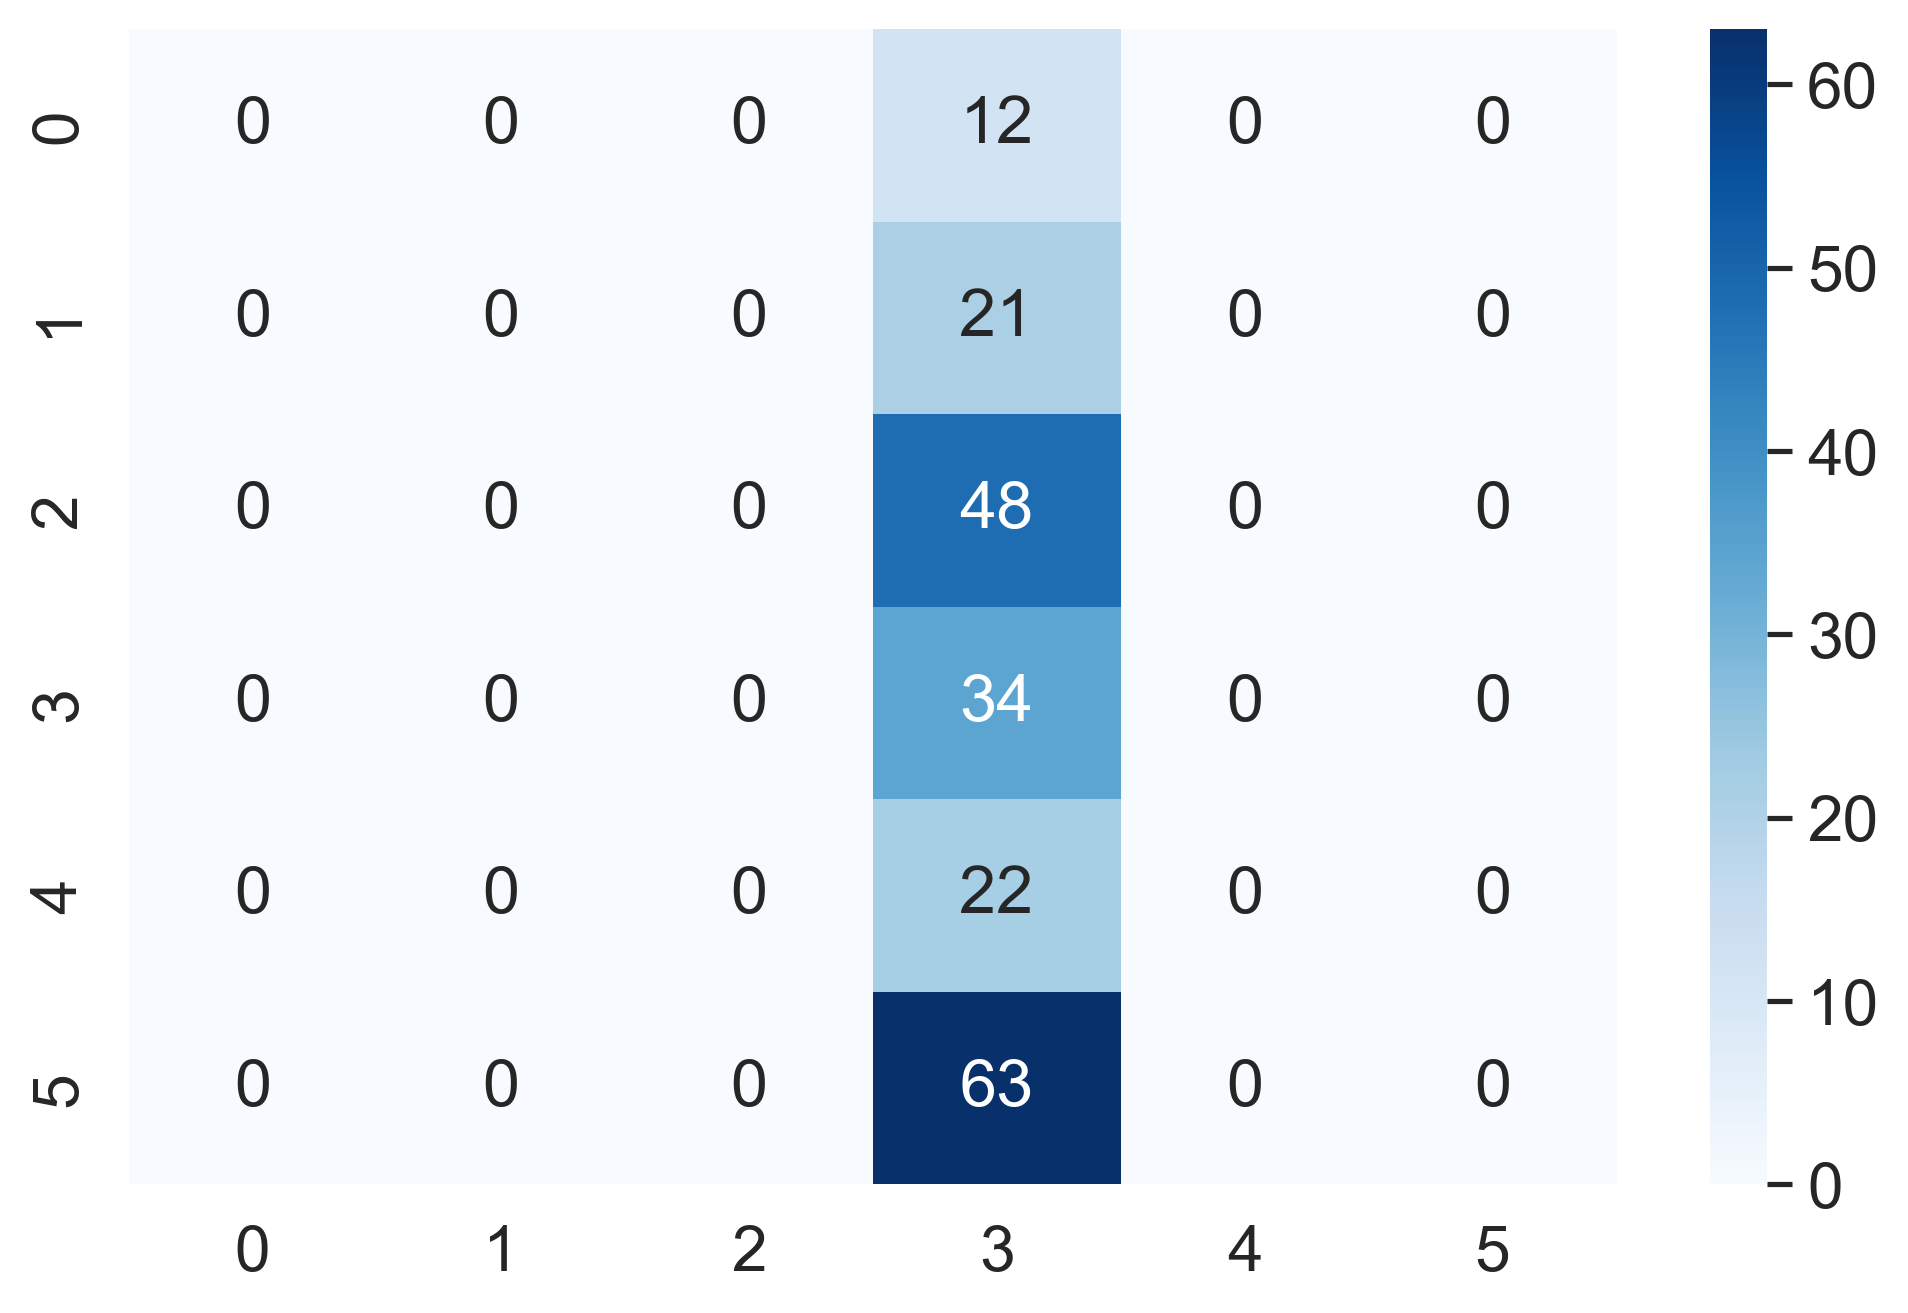

In [79]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline
cm = confusion_matrix(predict,actual)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, cmap='Blues')# font size

In [39]:
model.eval()
correct = 0
total = 0
actual = []
predict= []

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        actual = actual + labels.squeeze().tolist()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predict = predict + predicted.squeeze().tolist()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy}%')

100%|██████████████████████████████████████████████████████████████████████████████| 4271/4271 [02:05<00:00, 33.97it/s]

Test Accuracy: 16.80519784593772%


In [76]:
decode_dict = {3 : 'angry',5 : 'disgust', 4 : 'fear', 1 : 'happy', 0: 'neutral', 2 : 'sad'}
def decode(idx): return decode_dict[idx]

In [77]:
for i in range(len(predict)):
    predict[i] = decode(predict[i])
    actual[i] = decode(actual[i])

<AxesSubplot:>

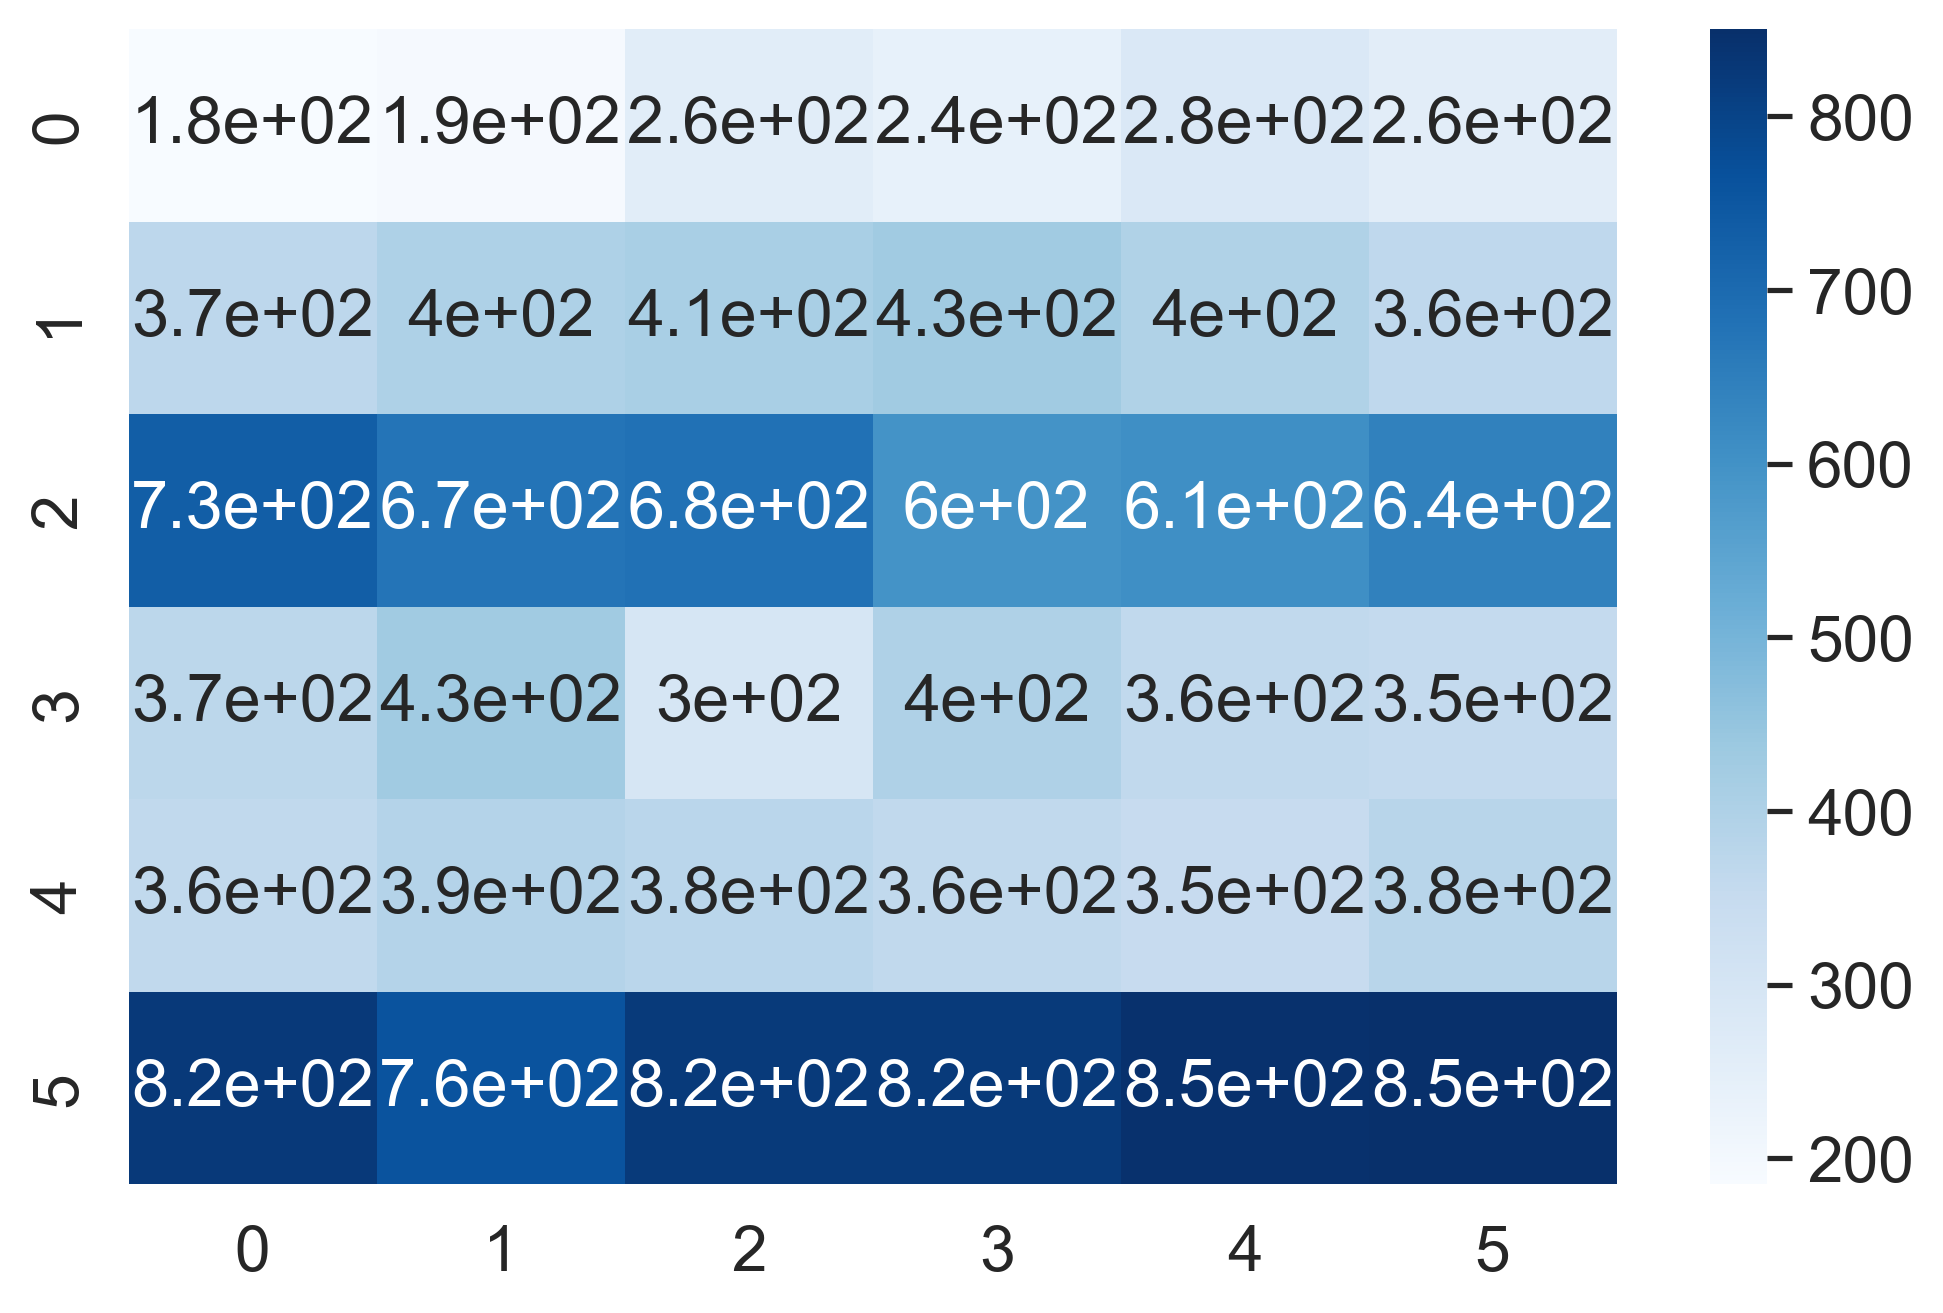

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline
cm = confusion_matrix(predict,actual)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, cmap='Blues')# font size

<AxesSubplot:>

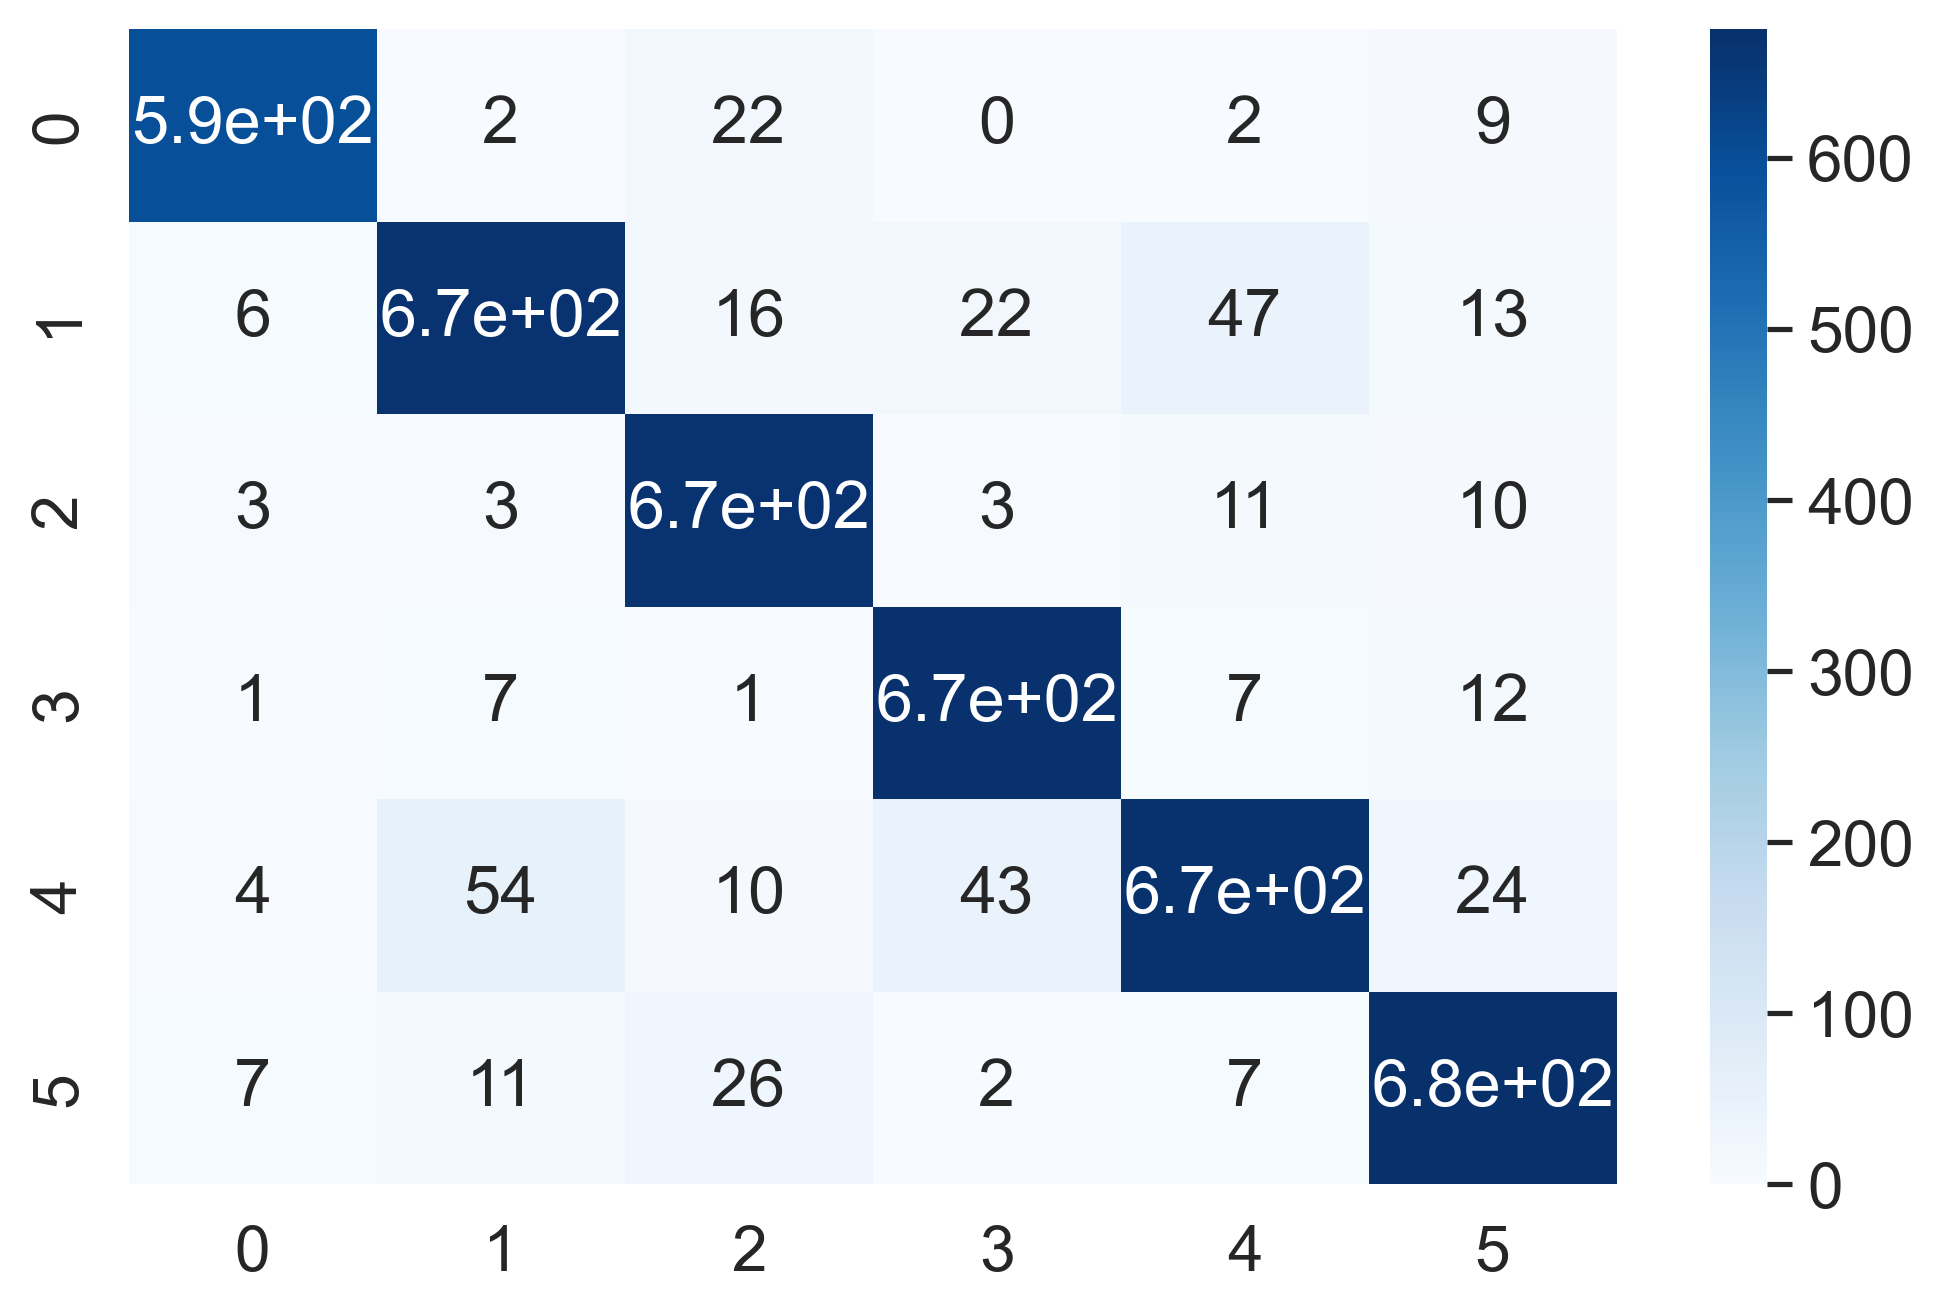

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline
cm = confusion_matrix(predict,actual)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, cmap='Blues')# font size

In [45]:
df = pd.read_csv("datasets/emotion_test.csv")

In [46]:
df = df[["wav_id","상황"]]

In [58]:
from tqdm import tqdm

In [59]:
df.iloc[0][0]

'5f7940c59e04b149046cc19a'

In [ ]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

In [90]:
emotion_dic = {'anger': 3, 'angry': 3, 'disgust': 5, 'fear': 4, 'happy': 1, 'happiness': 1,
                               'neutral': 0, 'sad': 2, 'sadness': 2, 'surprise': 6}

def encode(label):
    return emotion_dic.get(label)

In [91]:
import librosa
from pydub import AudioSegment, effects

In [92]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    effects.normalize(raw_audio)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    if (len(trimmed)>180000):
        padded = trimmed[:180000]
    else:
        padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [93]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

In [77]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for i in tqdm(range(len(df))):
    try:
        if (encode(df.iloc[i][1])==6): continue
        y, sr = preprocess_audio("datasets/emotion_audio_data/"+df.iloc[i][0]+".wav")
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(df.iloc[i][1]))
    except:
        print(f"Failed for path: datasets/emotion_audio_data/{df.iloc[i][0]}.wav")

100%|██████████████████████████████████████████████████████████████████████████████| 8793/8793 [17:30<00:00,  8.37it/s]


In [94]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)

In [26]:
tmpX = X.copy()
tmpy = y.copy()

In [27]:
class EmotionDataset(Dataset):
    def __init__(self, images, labels):
        self.images = []
        self.emotions = torch.Tensor(labels).to(torch.int64)
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

        for i in tqdm(range(len(images))):
            
            # MFCC를 이미지로 변환하여 크기를 조정합니다.
            image = Image.fromarray(images[i],"RGB")
            image = transform(image)
            self.images.append(image)
            
        self.len = len(images)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.emotions[idx]
        return image, label

In [37]:
model = resnet50(pretrained=True)
num_features = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_features, num_classes) 

In [38]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [30]:
dataset = EmotionDataset(X,y)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

100%|█████████████████████████████████████████████████████████████████████████████| 4331/4331 [00:04<00:00, 870.71it/s]


In [31]:
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [40]:
num_epochs = 100

In [95]:
dataset = EmotionDataset(X,y)
test_loader = DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True)

100%|█████████████████████████████████████████████████████████████████████████████| 4331/4331 [00:07<00:00, 607.47it/s]


In [41]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')
    return accuracy

In [96]:
test(model,test_loader)

100%|██████████████████████████████████████████████████████████████████████████████| 1082/1082 [00:23<00:00, 45.16it/s]

Test Accuracy: 94.29297597042513%


94.29297597042513

In [80]:
test(model,test_loader)

100%|██████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:48<00:00, 43.24it/s]

Test Accuracy: 21.616809116809115%


21.616809116809115

In [42]:
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    model.train()
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)                                                                          
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=running_loss / (len(dataloader)))
    test(model,test_loader)
    torch.save(model.state_dict(), "result/model_resnet50_final_{}.pth".format(epoch))
    
print('Training finished!')

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.83it/s]


Test Accuracy: 37.73148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.97it/s]


Test Accuracy: 24.76851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.75it/s]


Test Accuracy: 57.638888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 90.05it/s]


Test Accuracy: 57.175925925925924%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.04it/s]


Test Accuracy: 57.638888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.29it/s]


Test Accuracy: 63.19444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.73it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.14it/s]


Test Accuracy: 47.68518518518518%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.49it/s]


Test Accuracy: 59.25925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.94it/s]


Test Accuracy: 63.888888888888886%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.69it/s]


Test Accuracy: 61.574074074074076%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.36it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 78.64it/s]


Test Accuracy: 60.648148148148145%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.15it/s]


Test Accuracy: 64.12037037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.59it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.43it/s]


Test Accuracy: 62.96296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.38it/s]


Test Accuracy: 61.111111111111114%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.50it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.94it/s]


Test Accuracy: 59.72222222222222%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.36it/s]


Test Accuracy: 63.657407407407405%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 90.05it/s]


Test Accuracy: 62.73148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.29it/s]


Test Accuracy: 62.5%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 89.02it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 89.09it/s]


Test Accuracy: 59.9537037037037%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 90.58it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 91.50it/s]


Test Accuracy: 61.574074074074076%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.43it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.78it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.99it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.64it/s]


Test Accuracy: 67.82407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.36it/s]


Test Accuracy: 64.81481481481481%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 90.51it/s]


Test Accuracy: 64.58333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 89.24it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 89.02it/s]


Test Accuracy: 65.50925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.38it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 90.74it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 95.64it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.97it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.88it/s]


Test Accuracy: 62.5%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 95.30it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.04it/s]


Test Accuracy: 66.66666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.54it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.58it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.63it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 82.74it/s]


Test Accuracy: 62.73148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.08it/s]


Test Accuracy: 61.574074074074076%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.76it/s]


Test Accuracy: 58.7962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 89.53it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.86it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.90it/s]


Test Accuracy: 69.21296296296296%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.07it/s]


Test Accuracy: 65.50925925925925%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.15it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.50it/s]


Test Accuracy: 66.89814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.50it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.42it/s]


Test Accuracy: 61.574074074074076%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.38it/s]


Test Accuracy: 67.82407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.36it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.82it/s]


Test Accuracy: 64.58333333333333%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.29it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.56it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.96it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.38it/s]


Test Accuracy: 65.74074074074075%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.87it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.87it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.22it/s]


Test Accuracy: 69.44444444444444%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.17it/s]


Test Accuracy: 59.72222222222222%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.93it/s]


Test Accuracy: 64.35185185185185%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.80it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.22it/s]


Test Accuracy: 65.97222222222223%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.97it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.82it/s]


Test Accuracy: 67.82407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.94it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.36it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.51it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.62it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 84.49it/s]


Test Accuracy: 66.89814814814815%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.57it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.14it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.94it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.80it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.43it/s]


Test Accuracy: 68.75%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.87it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.93it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 83.44it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.59it/s]


Test Accuracy: 66.66666666666667%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 76.15it/s]


Test Accuracy: 70.13888888888889%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.87it/s]


Test Accuracy: 68.98148148148148%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 88.36it/s]


Test Accuracy: 68.28703703703704%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.42it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.22it/s]


Test Accuracy: 68.51851851851852%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.86it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 80.34it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 85.56it/s]


Test Accuracy: 66.43518518518519%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 87.01it/s]


Test Accuracy: 67.82407407407408%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 89.09it/s]


Test Accuracy: 67.5925925925926%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 90.13it/s]


Test Accuracy: 67.36111111111111%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.87it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.66it/s]


Test Accuracy: 67.12962962962963%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 90.81it/s]


Test Accuracy: 66.20370370370371%


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 86.04it/s]


Test Accuracy: 68.05555555555556%
Training finished!


In [57]:
state = torch.load("result/model_resnet50_final_85.pth")

In [58]:
model = resnet50()
num_features = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_features, num_classes) 
model.load_state_dict(state)

<All keys matched successfully>

In [59]:
model = model.to(device)

In [60]:
test(model,test_loader)

100%|██████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:30<00:00, 68.51it/s]

Test Accuracy: 19.931149097815766%


19.931149097815766

In [71]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks
import keras

In [72]:
MODEL = Sequential()
MODEL.add(layers.LSTM(256, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(256))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

NotImplementedError: Cannot convert a symbolic Tensor (lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [76]:
model = keras.models.load_model('.mdl_wts_256.hdf5')

NotImplementedError: Cannot convert a symbolic Tensor (lstm_6/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

## Test

In [8]:
import speech_recognition as speech

In [9]:
r = speech.Recognizer()
with speech.Microphone() as source:
    audio = r.listen(source)
    with open("input.wav","wb") as f:
        f.write(audio.get_wav_data())

In [15]:
emotion_decode = {
    0 : 'neutral',
    1 : 'happy',
    2 : 'sad', 
    3 : 'angry', 
    4 : 'fear', 
    5 : 'disgust'
}

In [10]:
import librosa
from pydub import AudioSegment, effects

In [10]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    if (len(trimmed)>180000):
        padded = trimmed[:180000]
    else:
        padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [11]:
input_wav = "../input.wav"

FRAME_LENGTH = 2048
HOP_LENGTH = 512


y, sr = preprocess_audio(input_wav)
zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
    
X = np.concatenate((
    np.swapaxes(zcr, 0, 1), 
    np.swapaxes(rms, 0, 1), 
    np.swapaxes(mfcc, 0, 1)), 
    axis=1
)
X = X.astype('float32')

In [8]:
input_wav = "../input.wav"

FRAME_LENGTH = 2048
HOP_LENGTH = 512

try: 
    y, sr = preprocess_audio(input_wav)
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
except:
    print(f"Failed for path: {input_wav}")
    
X = np.concatenate((
    np.swapaxes(zcr, 0, 1), 
    np.swapaxes(rms, 0, 1), 
    np.swapaxes(mfcc, 0, 1)), 
    axis=1
)
X = X.astype('float32')

Failed for path: ../input.wav


NameError: name 'zcr' is not defined

In [4]:
from emotion_model import emotion_predict

In [5]:
result = emotion_predict(X)

In [6]:
print(result)

neutral


In [57]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

image = Image.fromarray(X,"RGB")
image = transform(image)
image = image.unsqueeze(dim=0)

In [49]:
state = torch.load("test/result/model_resnet_new_all_55.pth")

In [50]:
model = resnet18()
num_features = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_features, num_classes) 
model.load_state_dict(state)

<All keys matched successfully>

In [58]:
model.eval()
result = model.forward(image)

In [59]:
emotion_decode[torch.argmax(result.squeeze()).item()]

'neutral'

In [61]:
import nemo.collections.asr as nemo_asr
asr_net = nemo_asr.models.ASRModel.from_pretrained("eesungkim/stt_kr_conformer_transducer_large")

[NeMo W 2023-06-13 00:33:58 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-06-13 00:33:59 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.


[NeMo I 2023-06-13 00:34:01 mixins:170] Tokenizer SentencePieceTokenizer initialized with 2261 tokens


[NeMo W 2023-06-13 00:34:02 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/public/rw/chris/manifests/ksponspeech//train.json
    sample_rate: 16000
    batch_size: 8
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: true
    trim_silence: false
    max_duration: 17
    min_duration: 0.1
    shuffle_n: 2048
    
[NeMo W 2023-06-13 00:34:02 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /data/public/rw/chris/manifests/ksponspeech//dev.json
    sample_rate: 16000
    batch_size: 16
    shuffle: false
    num_workers: 8
    pin_memory: true
    use_start_e

[NeMo I 2023-06-13 00:34:02 features:287] PADDING: 0
[NeMo I 2023-06-13 00:34:03 rnnt_models:206] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': 5}
[NeMo I 2023-06-13 00:34:03 audio_preprocessing:517] Numba CUDA SpecAugment kernel is being used
[NeMo I 2023-06-13 00:34:04 save_restore_connector:249] Model EncDecRNNTBPEModel was successfully restored from C:\Users\good\.cache\huggingface\hub\models--eesungkim--stt_kr_conformer_transducer_large\snapshots\fdc8412fe0d089913524767b20ff244ff1007ed0\stt_kr_conformer_transducer_large.nemo.


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
asr_net = asr_net.to(device)

In [64]:
asr_net.transcribe(['input.wav'])

(['이엇 허'], ['이엇 허'])